<a href="https://colab.research.google.com/github/DavidRiemer02/DataMiningProj/blob/main/DataMiningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, array_distinct, desc
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType

from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from nltk.corpus import stopwords



Initialize spark context

In [2]:
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Prepare the Data

Read in the data

In [3]:
train = spark.read.csv('Data/train.csv', header=True, inferSchema=True)

In [4]:
train.printSchema()
train.show(10, truncate=False)

root
 |-- ItemID: integer (nullable = true)
 |-- Sentiment: integer (nullable = true)
 |-- SentimentText: string (nullable = true)

+------+---------+------------------------------------------------------------------------------------------------------------------------------------+
|ItemID|Sentiment|SentimentText                                                                                                                       |
+------+---------+------------------------------------------------------------------------------------------------------------------------------------+
|1     |0        |                     is so sad for my APL friend.............                                                                       |
|2     |0        |                   I missed the New Moon trailer...                                                                                 |
|3     |1        |              omg its already 7:30 :O                                                     

Sentiment Count

+---------+-----+
|Sentiment|count|
+---------+-----+
|        1|56462|
|        0|43538|
+---------+-----+



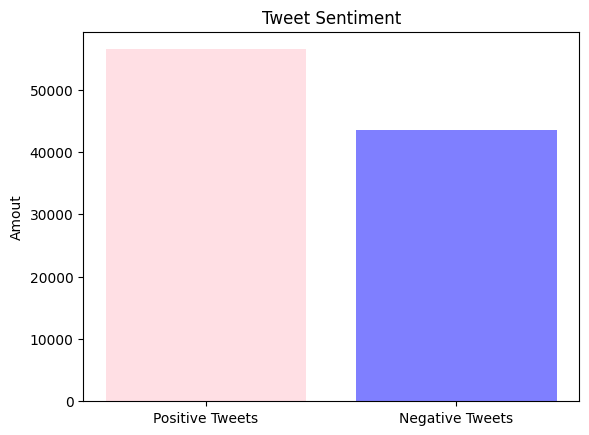

In [5]:
# get the count of each sentiment
train.groupBy("Sentiment").count().orderBy(col("count").desc()).show()

noPosTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[0][1]
noNegTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[1][1]

objects = ('Positive Tweets', 'Negative Tweets')
y_pos=(np.arange(len(objects)))
performance = (noPosTweets, noNegTweets)
plt.bar(objects, performance, align='center', alpha=0.5, color=['pink', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('Amout')
plt.title('Tweet Sentiment')
plt.show()


Most number of words in a tweet: 70
Average number of words in a tweet: 15.0
Least number of words in a tweet: 1
Number of tweets with more than 20 words: 72796
Number of tweets with 15 words: 4167


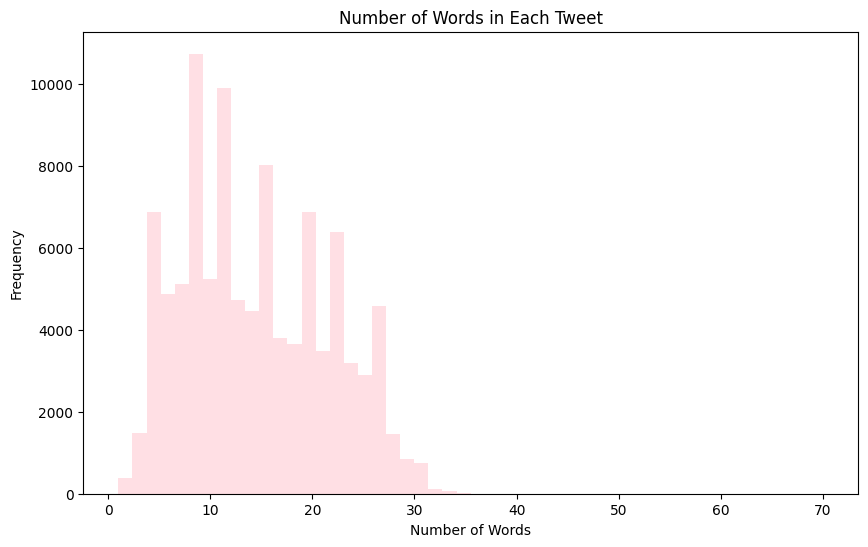

In [6]:
#Collect the number of words in each tweet
numberofWords = []
for rows in train.select("SentimentText").collect():
    numberofWords.append(len(rows.SentimentText.split(" ")))
numberofWords
#Creat a graph of the number of words in each tweet
plt.figure(figsize=(10,6))
plt.hist(numberofWords, bins=50, alpha=0.5, color='pink')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words in Each Tweet')
print('Most number of words in a tweet:', max(numberofWords))
print('Average number of words in a tweet:', np.mean(numberofWords).round(0))
print('Least number of words in a tweet:', min(numberofWords))
#How many tweets have more than 20 words?
print('Number of tweets with more than 20 words:', sum(i < 20 for i in numberofWords))
#How many tweets had 15 words
print('Number of tweets with 15 words:', sum(i == 15 for i in numberofWords))

Remove stopwords we do not need from the train data \ Transform the tweets into vectors of words

In [7]:
# Add a column with just words
regexTokenizer = RegexTokenizer(inputCol="SentimentText", outputCol="words", pattern="\\W")

# Remove the stop words
english_stop_words = stopwords.words('english')
english_stop_words.extend(['http', 'https', 'amp', 'rt', 't', 'c', 'the', 'www', 'com'])
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="filtered").setStopWords(english_stop_words)

#converts words into numerical values
hashingTF = HashingTF(inputCol=stopwordsRemover.getOutputCol(), outputCol="features")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF]).fit(train)

dataset = pipeline.transform(train).select("Sentiment", "filtered", "features")
dataset = dataset.withColumn("Sentiment", dataset["Sentiment"].cast(IntegerType()))

dataset.show(truncate=False, n=5)
dataset.printSchema()

+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                   |features                                                                                                                                                         |
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[sad, apl, friend]                                                                         |(262144,[74520,74989,125638],[1.0,1.0,1.0])                                                        

#Run Algorithms on the data

##Run Clustering-algorithms to find smiliar words

In [8]:
# Transform the data into a list of lists in order vor gensim and word2vec to work properly
sentences = [data[0] for data in dataset.
             select('filtered').collect()]

In [9]:
w2vModel = Word2Vec(sentences=sentences, vector_size=2000, workers=1, seed=1337)
w2vModel.save("word2vec.model")

In [10]:
w2vModel.wv.most_similar("happy")

[('birthday', 0.8686365485191345),
 ('mother', 0.824141800403595),
 ('mothers', 0.8154795169830322),
 ('camper', 0.8049947619438171),
 ('catirah', 0.7932088971138),
 ('belated', 0.7688307166099548),
 ('bday', 0.7297670841217041),
 ('fathers', 0.7278352379798889),
 ('tb', 0.727358341217041),
 ('wonderful', 0.7217618823051453)]

In [11]:
listHappy=w2vModel.wv.most_similar("happy")
listsad=w2vModel.wv.most_similar("sad")
listgood=w2vModel.wv.most_similar("good")
listbad=w2vModel.wv.most_similar("bad")
#Select only the words from the list
listHappy=[x[0] for x in listHappy]
listsad=[x[0] for x in listsad]
listgood=[x[0] for x in listgood]
listbad=[x[0] for x in listbad]
#Create a dataframe 
w2vDataFrame = pd.DataFrame({'Happy': listHappy, 'Sad': listsad, 'Good': listgood, 'Bad': listbad})
w2vDataFrame

,Happy,Sad,Good,Bad
0,birthday,jealous,lovely,sick
1,mother,kinda,nice,horrible
2,mothers,sucks,great,sucks
3,camper,bad,wonderful,crap
4,catirah,cuddlyalex,bexmith,pain
5,belated,amelia_grace,rough,poor
6,bday,shit,_ynnie36,hate
7,fathers,horrible,almienova,kinda
8,tb,face,cglade,unloved
9,wonderful,andreakoeln,perfect,terrible


In [12]:
#Retrieve the 750 most "important words" in the dataset
w2vModel.wv.index_to_key[:100]
#Fit a 2D PCA model to the vectors
vectors = w2vModel.wv[w2vModel.wv.key_to_index]
wordsArray = list(w2vModel.wv.key_to_index)[:750]
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)


#Prepare a dataframe t make 
words = pd.DataFrame(wordsArray)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]    
PCA_data_labeled =PCA_final[['word','x_values','y_values']]

Reduce dimensions using SVD to plot the Data

In [13]:
from scipy.linalg import svd
from numpy import zeros, diag
#get the most important words (get first 750 rows of vectors)
vectors750 = w2vModel.wv[w2vModel.wv.key_to_index][:750]

U, s, VT = svd(vectors750, full_matrices=False)
Sigma = zeros((vectors750.shape[0], vectors750.shape[1]))
Sigma[:vectors750.shape[0], :vectors750.shape[0]] = diag(s)
n_elements = 2
Sigma = Sigma[:, :n_elements]
VT = VT[:n_elements, :]
# reconstruct
B = U.dot(Sigma.dot(VT))
# transform
SVD_result = U.dot(Sigma)
SVD_resultDF = pd.DataFrame(SVD_result)
SVD_resultDF['x_values'] =SVD_resultDF.iloc[0:, 0]
SVD_resultDF['y_values'] =SVD_resultDF.iloc[0:, 1]
SVD_final = pd.merge(words, SVD_resultDF, left_index=True, right_index=True)
SVD_final['word'] =SVD_final.iloc[0:, 0]    
SVD_data_labeled =SVD_final[['word','x_values','y_values']]

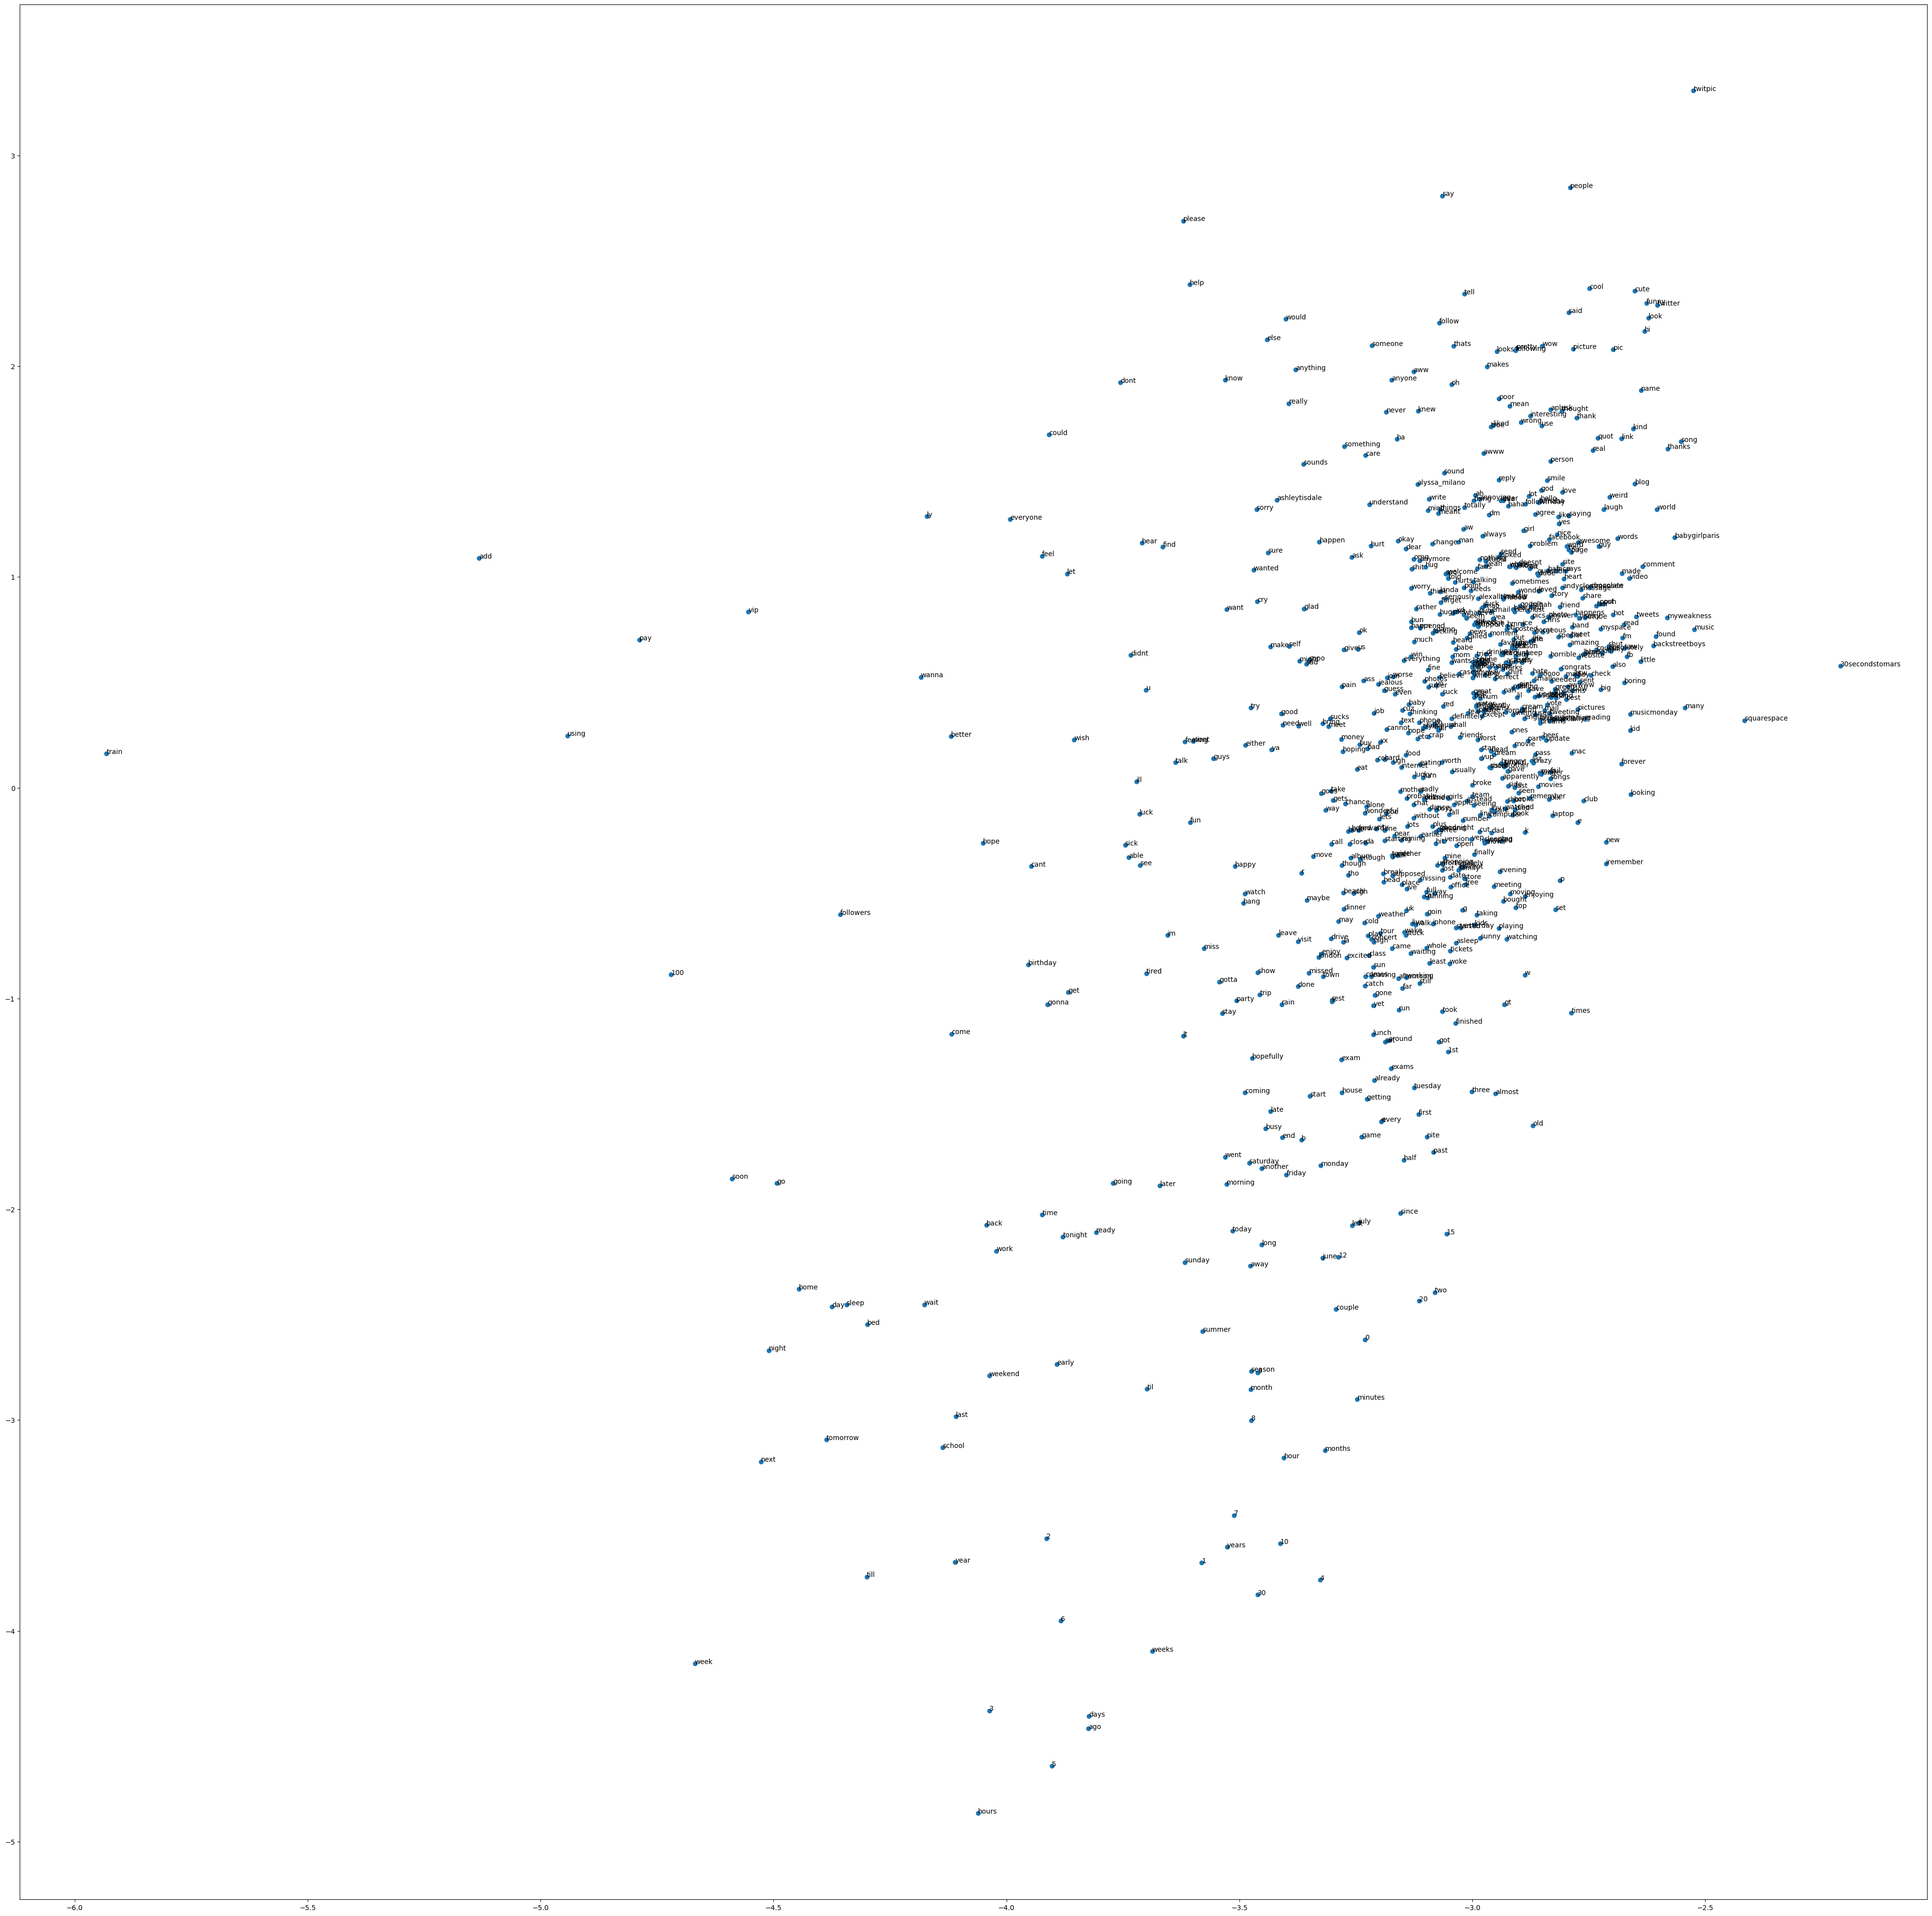

In [14]:
fig = plt.figure()
#zoom out of the graph to see the words more clearly
fig.set_figheight(50)
fig.set_figwidth(50)
ax = fig.add_subplot(1, 1, 1)
#label the points with their respective words
for word, x, y in zip(SVD_data_labeled['word'], SVD_data_labeled['x_values'], SVD_data_labeled['y_values']):
    plt.annotate(word, (x, y))
plt.scatter(SVD_data_labeled['x_values'], SVD_data_labeled['y_values'])

In [15]:
#Run k-means and color the the points in the graph to their respective cluster
#Run k-means on the SVD_data_labeled dataframe
kmeans = KMeans(n_clusters=20)
kmeans.fit(SVD_data_labeled[['x_values','y_values']])
y_kmeans = kmeans.predict(SVD_data_labeled[['x_values','y_values']])

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


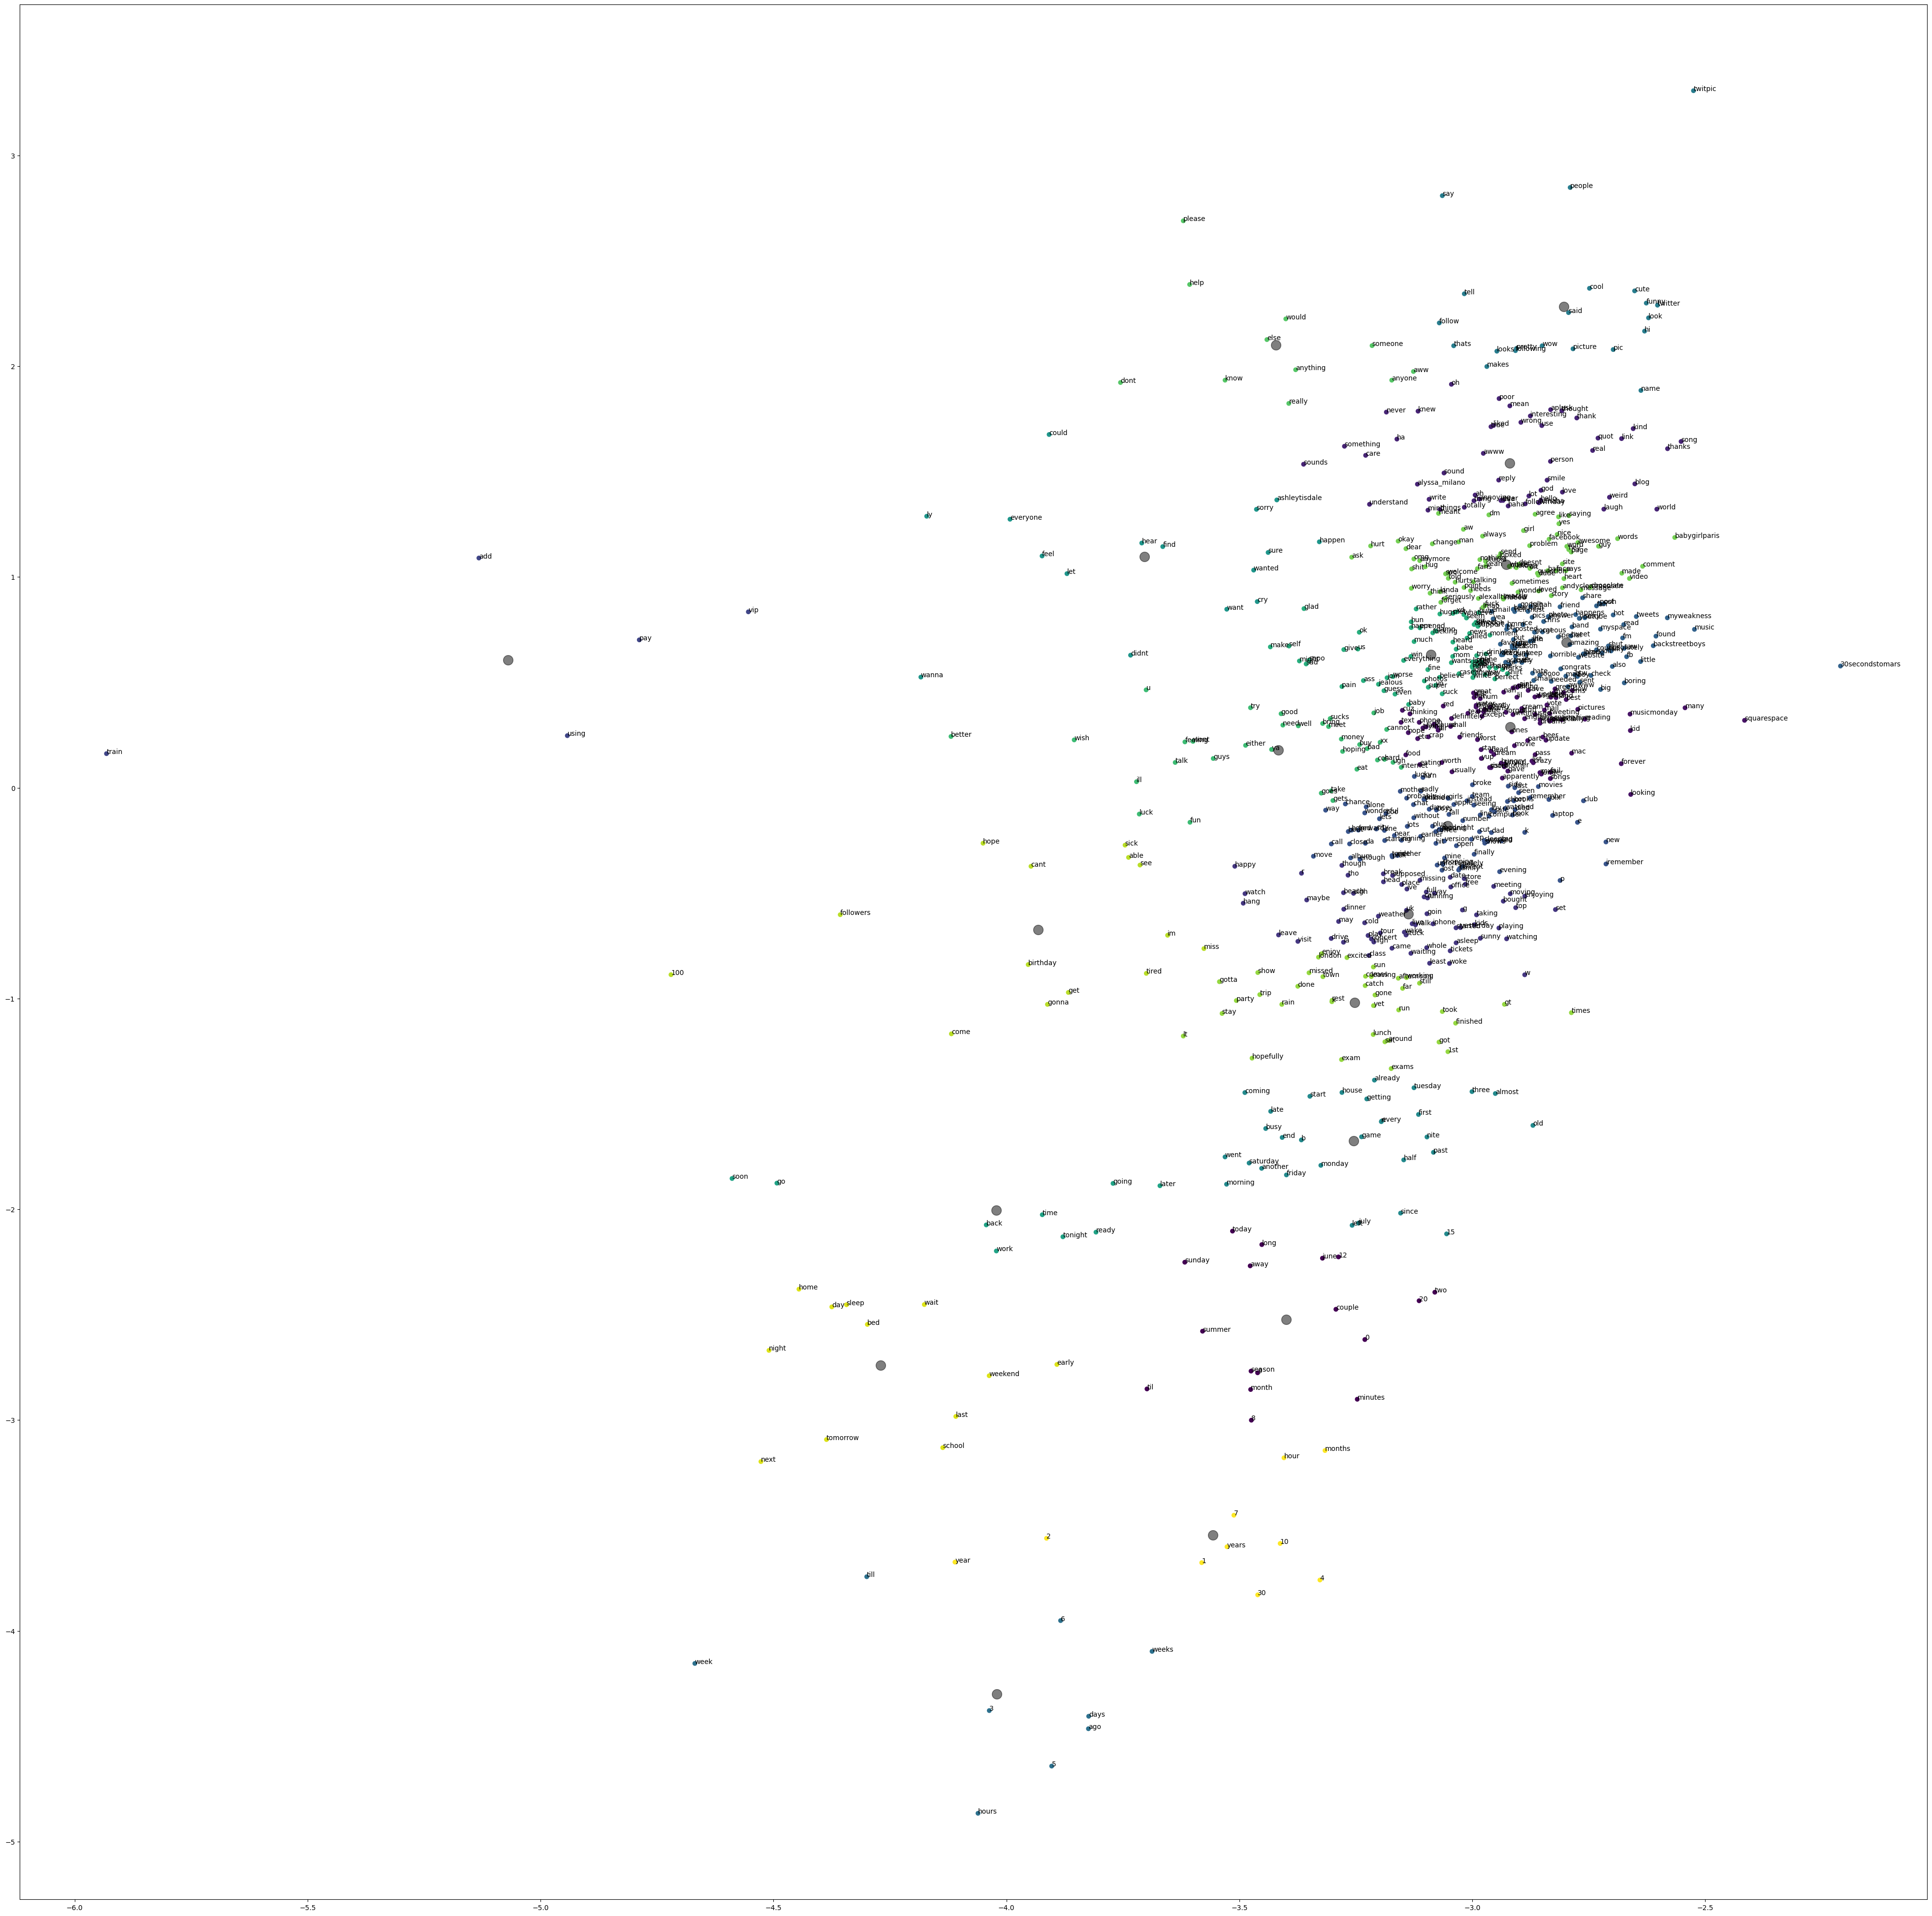

In [16]:
fig = plt.figure()
#zoom out of the graph to see the words more clearly
fig.set_figheight(50)
fig.set_figwidth(50)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(SVD_data_labeled['x_values'], SVD_data_labeled['y_values'], c=y_kmeans, cmap='viridis')
#Plot the centroids of the clusters
centers = kmeans.cluster_centers_
for word, x, y in zip(SVD_data_labeled['word'], SVD_data_labeled['x_values'], SVD_data_labeled['y_values']):
    plt.annotate(word, (x, y))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

##Run A-propri on the word vetors, to see which words are most often used together

In [17]:
#Split the number of tweets into 2 groups: One with positive tweets and one with negative tweets
positiveTweets = dataset.filter(dataset.Sentiment == 1)
negativeTweets = dataset.filter(dataset.Sentiment == 0)
aprioriDFP = positiveTweets.withColumn("wordsWithoutDupes", array_distinct("filtered"))
aprioriDFN = negativeTweets.withColumn("wordsWithoutDupes", array_distinct("filtered"))
#Number of unique words
fpGrowth = FPGrowth(itemsCol="wordsWithoutDupes", minSupport=0.002, minConfidence=0.1)
apriori_modelP = fpGrowth.fit(aprioriDFP)
apriori_modelN = fpGrowth.fit(aprioriDFN)

In [18]:
apriori_modelP.freqItemsets.sort(desc("freq")).show(apriori_modelP.freqItemsets.count())
print("Number of frequent itemsets: " + str(apriori_modelP.freqItemsets.count()))
apriori_modelP.associationRules.show()
print("Number of association rules: " + str(apriori_modelP.associationRules.count()))


+--------------------+----+
|               items|freq|
+--------------------+----+
|              [good]|4062|
|            [thanks]|3547|
|              [love]|3210|
|               [lol]|3153|
|              [like]|3024|
|              [quot]|2873|
|               [get]|2601|
|                 [u]|2503|
|              [know]|2358|
|               [day]|1991|
|               [one]|1986|
|              [well]|1966|
|              [haha]|1922|
|               [see]|1844|
|             [great]|1737|
|              [time]|1666|
|             [think]|1558|
|              [hope]|1535|
|                [go]|1519|
|             [thank]|1464|
|               [got]|1430|
|                [oh]|1399|
|              [yeah]|1292|
|            [really]|1258|
|              [much]|1246|
|               [hey]|1245|
|             [going]|1238|
|             [would]|1214|
|              [back]|1192|
|               [yes]|1184|
|                [im]|1181|
|              [nice]|1168|
|               [new

In [19]:
apriori_modelN.freqItemsets.sort(desc("freq")).show(apriori_modelN.freqItemsets.count())
print("Number of frequent itemsets: " + str(apriori_modelN.freqItemsets.count()))
apriori_modelN.associationRules.show()
print("Number of association rules: " + str(apriori_modelN.associationRules.count()))

+--------------------+----+
|               items|freq|
+--------------------+----+
|               [get]|2522|
|              [like]|2260|
|              [know]|2084|
|             [sorry]|2021|
|                [go]|1968|
|               [lol]|1965|
|                 [u]|1828|
|              [work]|1619|
|              [good]|1615|
|               [one]|1586|
|                [im]|1579|
|              [miss]|1569|
|               [got]|1509|
|                [oh]|1497|
|               [sad]|1462|
|             [still]|1410|
|            [really]|1402|
|              [quot]|1396|
|             [going]|1363|
|              [want]|1343|
|               [see]|1332|
|               [day]|1319|
|              [time]|1307|
|             [think]|1275|
|              [wish]|1220|
|              [back]|1172|
|              [well]|1144|
|             [today]|1141|
|              [hope]|1118|
|               [bad]|1069|
|              [love]|1054|
|                 [2]|1045|
|              [yeah

##Train the model to predict Sentiment on the test data

In [20]:
#Split training and Testing
split_data=train.randomSplit([0.8,0.2])
trainSplit=split_data[0]
testSplit=split_data[1]
trainSplit = pipeline.transform(trainSplit).select("Sentiment", "filtered", "features")
testSplit = pipeline.transform(testSplit).select("Sentiment", "filtered", "features")

#Count the number of training tweets and testing tweets
print("Number of training tweets: " + str(trainSplit.count()))
print("Number of testing tweets: " + str(testSplit.count()))

trainSplit.show(5, truncate=False)
testSplit.show(5, truncate=False)

Number of training tweets: 79963
Number of testing tweets: 20037
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                   |features                                                                                                                                                         |
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[sad, apl, friend]                                                                         |(262144,[74520,74989,125638],[1.0,

In [21]:
lr = LogisticRegression(labelCol = 'Sentiment', featuresCol='features', maxIter=1000, regParam=0.01)
lrModel = lr.fit(trainSplit)
print("Done")

raw_prediction = lrModel.transform(testSplit)
raw_prediction.printSchema()

Done
root
 |-- Sentiment: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [22]:
Final_prediction = raw_prediction.select("filtered", "prediction", "Sentiment")
Final_prediction.show(n=4, truncate = False)

+----------------------------------------------------------------------------+----------+---------+
|filtered                                                                    |prediction|Sentiment|
+----------------------------------------------------------------------------+----------+---------+
|[juuuuuuuuuuuuuuuuussssst, chillin]                                         |0.0       |1        |
|[hmmmm, wonder, number]                                                     |1.0       |1        |
|[must, think, positive]                                                     |1.0       |0        |
|[cut, beard, growing, well, year, gonna, start, shaunamanu, happy, meantime]|1.0       |0        |
+----------------------------------------------------------------------------+----------+---------+
only showing top 4 rows



In [23]:
#Count the accuracy
correctPrediction = Final_prediction.filter(Final_prediction['prediction'] == Final_prediction['Sentiment']).count()
print("Number of correct predictions: " + str(correctPrediction))
Accuracy = correctPrediction/testSplit.count()*100
print("Accuracy: " + str(Accuracy))

Number of correct predictions: 13879
Accuracy: 69.26685631581574


In [26]:
#Build a confusion matrix
TP = Final_prediction.filter(Final_prediction['prediction'] == 1).filter(Final_prediction['Sentiment'] == 1).count()
TN = Final_prediction.filter(Final_prediction['prediction'] == 0).filter(Final_prediction['Sentiment'] == 0).count()
FP = Final_prediction.filter(Final_prediction['prediction'] == 1).filter(Final_prediction['Sentiment'] == 0).count()
FN = Final_prediction.filter(Final_prediction['prediction'] == 0).filter(Final_prediction['Sentiment'] == 1).count()
print("True Positives: " + str(TP))
print("True Negatives: " + str(TN))
print("False Positives: " + str(FP))
print("False Negatives: " + str(FN))

Py4JJavaError: An error occurred while calling o606.count.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:75)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:53)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:1623)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2707)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.$anonfun$apply$1(CoalesceShufflePartitions.scala:60)
	at scala.runtime.java8.JFunction0$mcI$sp.apply(JFunction0$mcI$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:57)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:33)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$optimizeQueryStage$1(AdaptiveSparkPlanExec.scala:163)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.optimizeQueryStage(AdaptiveSparkPlanExec.scala:162)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.newQueryStage(AdaptiveSparkPlanExec.scala:572)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:522)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:561)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:561)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:261)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:256)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:401)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:3626)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:3625)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:3625)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)


In [25]:
sc.stop()